# Fitting the Features to Models

This is a continuation of the data_exploration notebook, started for clarity.

First lets move all the features i want here:

In [52]:
import pandas as pd
from IPython.display import display
from math import radians, cos, sin, asin, sqrt
import scipy
from scipy.stats import zscore
from datetime import datetime

# Load the dataset
trainingSet = pd.read_csv("./data/X_train.csv")

############# TIME FEATURES

# Make sure the 'trans_date' and 'trans_time' are in the right datetime format
trainingSet['trans_date'] = pd.to_datetime(trainingSet['trans_date'])
trainingSet['trans_time'] = pd.to_timedelta(trainingSet['trans_time'].astype(str))

# Extract day of week and hour of day
trainingSet['day_of_week'] = trainingSet['trans_date'].dt.day_name()
trainingSet['hour_of_day'] = trainingSet['trans_time'].dt.components['hours']

# Define high-risk hours
high_risk_hours = set(range(21, 24)).union(set(range(0, 6)))

# Create the 'high_risk_time' feature based on 'hour_of_day'
trainingSet['high_risk_time'] = trainingSet['hour_of_day'].apply(lambda x: 1 if x in high_risk_hours else 0)

############# CATEGORY FEATURES

# Step 1: Calculate the mean and standard deviation for each category
category_stats = trainingSet.groupby('category')['amt'].agg(['mean', 'std']).reset_index()

# Rename the columns to be more descriptive
category_stats = category_stats.rename(columns={'mean': 'category_mean_amt', 'std': 'category_std_amt'})

# Step 2: Merge these statistics back into the original dataframe
trainingSet = trainingSet.merge(category_stats, how='left', on='category')

# Step 3: Create a binary feature that flags a transaction as an outlier
def is_outlier(row):
    if pd.isnull(row['category_std_amt']):  # If std is NaN, cannot determine if it's an outlier
        return 0
    lower_bound = row['category_mean_amt'] - 3 * row['category_std_amt']
    upper_bound = row['category_mean_amt'] + 3 * row['category_std_amt']
    return int(not lower_bound <= row['amt'] <= upper_bound)

trainingSet['category_outlier'] = trainingSet.apply(is_outlier, axis=1)

# There are also some high risk categories, so lets make a feature for that
# Define high-risk categories
high_risk_categories = ['shopping_net', 'entertainment', 'shopping_pos', 'misc_net']

# Create the 'high_risk_category' feature
trainingSet['high_risk_category'] = trainingSet['category'].isin(high_risk_categories).astype(int)

############# AMOUNT FEATURES

# Define the bins as per the peaks observed in the histogram
bins = [-1, 30, 250, 350, 800, 1000, float('inf')]
bin_labels = ['1', '2', '3', '4', '5', '6']
# '0-50', '250-350', '650-1200'

# Create the 'amount_bin' feature
trainingSet['amount_bin'] = pd.cut(trainingSet['amt'], bins=bins, labels=bin_labels)


############# DISTANCE FEATURES

# for generating distances

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great-circle distance between two points 
    on the Earth (specified in decimal degrees)
    """
    # Convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # Haversine formula
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of Earth in kilometers. Use 3956 for miles
    return c * r

# Now apply this function to the dataframe to create the distance feature
trainingSet['distance_from_home'] = trainingSet.apply(lambda row: haversine(row['long'], row['lat'], row['merch_long'], row['merch_lat']), axis=1)

############# DISTANCE & AMOUNT FEATURES

# Calculate the mean transaction amount and distance for each customer
customer_means = trainingSet.groupby('cc_num').agg({'amt': 'mean', 'distance_from_home': 'mean'}).rename(columns={'amt': 'mean_amt', 'distance_from_home': 'mean_distance'})

# Join the customer means back onto the transaction dataframe
trainingSet = trainingSet.join(customer_means, on='cc_num')

# Calculate deviations for amount and distance

trainingSet['amt_deviation'] = (trainingSet['amt'] - trainingSet['mean_amt']) / trainingSet['mean_amt']
trainingSet['distance_deviation'] = (trainingSet['distance_from_home'] - trainingSet['mean_distance']) / trainingSet['mean_distance']

trainingSet['amt_deviation_z'] = trainingSet.groupby('cc_num')['amt_deviation'].transform(zscore)
trainingSet['distance_deviation_z'] = trainingSet.groupby('cc_num')['distance_deviation'].transform(zscore)

trainingSet['atypical_transaction'] = ((trainingSet['amt_deviation_z'] > 3) | (trainingSet['distance_deviation_z'] > 3)).astype(int)


In [53]:
############# CONVERTING DOB TO AGE FEATURE
trainingSet['age'] = trainingSet['dob'].apply(lambda x: datetime.now().year - datetime.strptime(x, "%d/%m/%Y").year)

############# CONVERTING DAYS OF THE WEEK TO ISWEEKEND FEATURE

# consolidating the days of the week into a binary feature like "weekend" versus "weekday" could provide a more powerful 
# signal for the model by reducing the dimensionality and focusing on a broader pattern that might be more relevant to fraud detection.

# Create a new binary column 'is_weekend', where 1 indicates a weekend (Saturday or Sunday) and 0 indicates a weekday
trainingSet['is_weekend'] = trainingSet['day_of_week'].apply(lambda x: 1 if x in ['Saturday', 'Sunday'] else 0)

############# ONE HOT ENCODING GENDER FEATURE

# Use `pd.get_dummies` to one-hot encode the gender column
gender_dummies = pd.get_dummies(trainingSet['gender'], prefix='gender_encoding', drop_first=True).astype(int)

# Concatenate the new dummy columns with the original DataFrame
trainingSet = pd.concat([trainingSet, gender_dummies], axis=1)

############# ONE HOT ENCODING AMT_BIN FEATURE

# Use `pd.get_dummies` to one-hot encode the gender column
gender_dummies_2 = pd.get_dummies(trainingSet['amount_bin'], prefix='amt_bin').astype(int)

# Concatenate the new dummy columns with the original DataFrame
trainingSet = pd.concat([trainingSet, gender_dummies_2], axis=1)


display(trainingSet)

,Id,cc_num,merchant,category,amt,first,last,gender,street,city,...,atypical_transaction,age,is_weekend,gender_encoding_M,amt_bin_1,amt_bin_2,amt_bin_3,amt_bin_4,amt_bin_5,amt_bin_6
0,205743,5.596350e+15,fraud_Berge LLC,gas_transport,72.18,Joseph,Moody,M,5901 Foster Pine,Kenner,...,0,83,0,1,0,1,0,0,0,0
1,465349,4.311370e+18,"fraud_Eichmann, Bogan and Rodriguez",gas_transport,36.66,Phillip,Delacruz,M,26678 Lisa Locks Apt. 904,Iliff,...,0,55,1,1,0,1,0,0,0,0
2,17312,2.264940e+15,fraud_Ankunding-Carroll,travel,1.74,Juan,Sherman,M,5939 Garcia Forges Suite 297,San Antonio,...,0,29,1,1,1,0,0,0,0,0
3,234968,2.224100e+15,"fraud_Schumm, Bauch and Ondricka",grocery_pos,140.99,Sheri,Thomas,F,019 Kimberly Light Apt. 039,Kings Bay,...,0,61,0,0,0,1,0,0,0,0
4,194255,3.527540e+15,fraud_Gerlach Inc,shopping_net,1722.19,Teresa,Stein,F,2838 White Fields Apt. 473,Brunson,...,1,50,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
486249,502355,4.292900e+18,fraud_Wilkinson PLC,kids_pets,4.30,Jeffrey,Smith,M,135 Joseph Mountains,Sula,...,0,29,1,1,1,0,0,0,0,0
486250,527890,2.131570e+14,fraud_Kuvalis Ltd,gas_transport,34.85,Adam,Santos,M,725 Jo Trace Apt. 102,Glendale,...,0,42,1,1,0,1,0,0,0,0
486251,253663,6.763730e+11,"fraud_Hodkiewicz, Prohaska and Paucek",travel,9.22,Vicki,Mendoza,F,3645 Atkins Island Apt. 238,Esbon,...,0,37,0,0,1,0,0,0,0,0
486252,33882,3.026700e+13,fraud_Kihn-Fritsch,food_dining,9.39,Sarah,Foster,F,77872 Andrea Glen Apt. 543,Ford,...,0,48,0,0,1,0,0,0,0,0


Lets start with KNN to see how fairs agains the data.

### Applying KNN - K Nearest Neighbors

In [62]:
# Step 1: Preparing the data
# Dropping non-numeric and target columns
X = trainingSet.drop(['age','gender','category','amount_bin','zip','city_pop','dob','hour_of_day','is_fraud','day_of_week','Id','city','job', 'cc_num','merchant','lat','long','trans_num', 'first',	'last', 'street','state', 'unix_time','merch_lat','merch_long','trans_date','trans_time'], axis=1)
X.to_csv("./data/KNN_prepped_data.csv", index=False)
y = trainingSet['is_fraud']

In [63]:
display(X)

,amt,high_risk_time,category_mean_amt,category_std_amt,category_outlier,high_risk_category,distance_from_home,mean_amt,mean_distance,amt_deviation,...,distance_deviation_z,atypical_transaction,is_weekend,gender_encoding_M,amt_bin_1,amt_bin_2,amt_bin_3,amt_bin_4,amt_bin_5,amt_bin_6
0,72.18,0,63.543945,15.822162,0,0,50.737315,57.797517,80.336668,0.248843,...,-0.969531,0,0,1,0,1,0,0,0,0
1,36.66,0,63.543945,15.822162,0,0,104.392466,63.399076,76.229090,-0.421758,...,0.978368,0,1,1,0,1,0,0,0,0
2,1.74,0,111.232725,594.731563,0,0,100.963045,40.816940,80.750118,-0.957371,...,0.681020,0,1,1,1,0,0,0,0,0
3,140.99,1,115.831241,51.518686,0,0,69.869598,59.066132,80.765233,1.386985,...,-0.375547,0,0,0,0,1,0,0,0,0
4,1722.19,0,83.276649,237.727111,1,1,92.423012,63.335838,78.770719,26.191398,...,0.456431,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
486249,4.30,0,57.387894,48.535704,0,0,81.383486,70.500530,70.807763,-0.939008,...,0.358629,0,1,1,1,0,0,0,0,0
486250,34.85,1,63.543945,15.822162,0,0,103.949599,72.850973,76.856481,-0.521626,...,0.928646,0,1,1,0,1,0,0,0,0
486251,9.22,1,111.232725,594.731563,0,0,86.264441,64.853593,77.254689,-0.857834,...,0.304841,0,0,0,1,0,0,0,0,0
486252,9.39,1,50.733305,48.274721,0,0,86.961172,71.111471,76.401974,-0.867954,...,0.366162,0,0,0,1,0,0,0,0,0


### Explaining Feature Selection:

- **Removed Non-Numeric and Identifier Features:** I removed identifiers such as Id, cc_num, trans_num, as well as text fields like city, merchant, first, last, street, state, and date-time fields like trans_date and trans_time. These wouldn't be useful for KNN and could lead to overfitting or privacy concerns.

- **Removed Geolocation Features:** I excluded direct geolocation features (lat, long, merch_lat, merch_long) and chose to keep derived features like distance_from_home, which are more informative for behavior patterns.

- **Kept Behavioral Features:** Features like category_mean_amt, category_std_amt, category_outlier, high_risk_category, amount_bin, high_risk_time, amt_deviation, distance_deviation, amt_deviation_z, distance_deviation_z, and atypical_transaction are kept since they describe transactional behavior and risk.

- **Included Demographic Features:** I included only gender for the time being, not exactly sure what this adds but will remove if its not adding to the model. Zip, job, City_Pop, and dob might be less directly related to fraud. Inlcuding job and dob could be overfitting as they dont directly link to fraud. I've converted dob to age currently but will see how relevant it is.

- **Categorical Variable Encoding:** I removed the category feature as I have alot of numerical data on it. And converted the day_of_week feature into a binary encoding of whether its the weekend or not.

In [60]:
# Now, there doesnt seem to be any null values, but let's verify:
null_counts = X.isnull().sum()
print("\nNumber of null values in each column:\n", null_counts)


Number of null values in each column:
 amt                     0
high_risk_time          0
category_mean_amt       0
category_std_amt        0
category_outlier        0
high_risk_category      0
distance_from_home      0
mean_amt                0
mean_distance           0
amt_deviation           0
distance_deviation      0
amt_deviation_z         0
distance_deviation_z    0
atypical_transaction    0
age                     0
is_weekend              0
gender_encoding_M       0
amt_bin_1               0
amt_bin_2               0
amt_bin_3               0
amt_bin_4               0
amt_bin_5               0
amt_bin_6               0
dtype: int64


In [68]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline

# Step 1 Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Scale the Data
# Define which columns need to be scaled; it should be numeric columns excluding binary flags
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_features.remove('is_weekend')  # Remove binary flags if included
numeric_features.remove('high_risk_time')  
numeric_features.remove('category_outlier') 
numeric_features.remove('high_risk_category') 
numeric_features.remove('atypical_transaction')  
numeric_features.remove('gender_encoding_M') 
numeric_features.remove('amt_bin_1') 
numeric_features.remove('amt_bin_2') 
numeric_features.remove('amt_bin_3') 
numeric_features.remove('amt_bin_4') 
numeric_features.remove('amt_bin_5') 
numeric_features.remove('amt_bin_6') 

# Create a column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features)
    ], remainder='passthrough'  # This will keep the one-hot encoded columns untouched
)


# Step 3: Initializing lists to store accuracies
train_accuracies = []
test_accuracies = []

# Step 4: Create a pipeline that includes scaling and the classifier
# We'll loop over the 'n_neighbors' parameter in the classifier
for K in range(1, 21):
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier(n_neighbors=K))
    ])

    # Train the pipeline on the training data
    pipeline.fit(X_train, y_train)
    
    # Recording accuracies
    train_accuracy = pipeline.score(X_train, y_train)
    test_accuracy = pipeline.score(X_test, y_test)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)



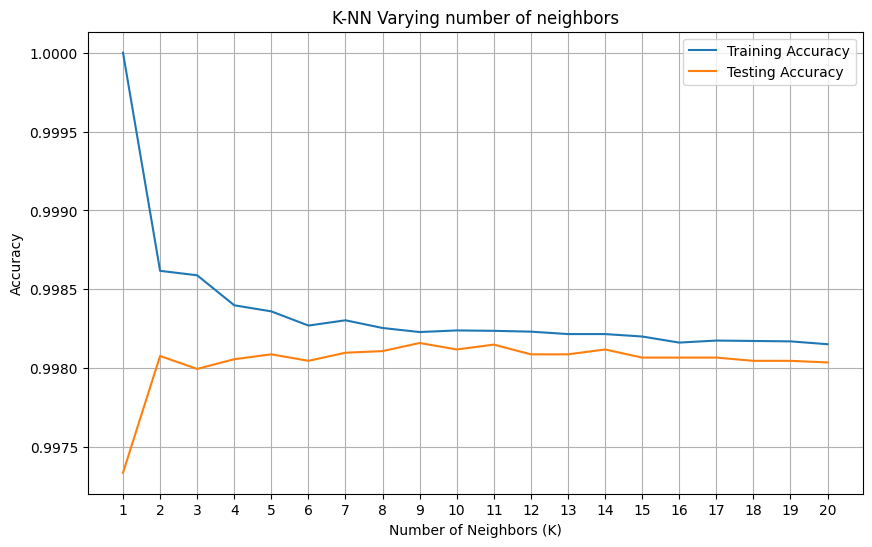

In [69]:
import matplotlib.pyplot as plt

# Step 4: Plotting accuracies
plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), train_accuracies, label='Training Accuracy')
plt.plot(range(1, 21), test_accuracies, label='Testing Accuracy')
plt.title('K-NN Varying number of neighbors')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Accuracy')
plt.xticks(np.arange(1, 21, 1))
plt.legend()
plt.grid(True)
plt.show()

This took way too long to run and lead to subapr results, so I need better features with less multicolinearity, so i can run the model on the least number of neighbors. But let me try other models aswell.

In [70]:
# from the plot I determined k=7 is best
best_k = 2

# Now, create a pipeline with the scaler and KNN using the best k
best_knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=best_k))
])

# Fit the model on the entire training data
best_knn_pipeline.fit(X_train, y_train)

# Now you can use best_knn_pipeline to make predictions on new data, 
# or to evaluate its performance further on the test set
y_pred = best_knn_pipeline.predict(X_test)

# Evaluate the final model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[96864    22]
 [  165   200]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     96886
         1.0       0.90      0.55      0.68       365

    accuracy                           1.00     97251
   macro avg       0.95      0.77      0.84     97251
weighted avg       1.00      1.00      1.00     97251



Here's an interpretation:

- True Negatives (TN): 96842, meaning that 96842 non-fraudulent transactions were correctly identified.
- False Positives (FP): 44, meaning that 44 non-fraudulent transactions were incorrectly flagged as fraudulent.
- False Negatives (FN): 155, meaning that 155 fraudulent transactions were missed by the model and were incorrectly identified as non-fraudulent.
- True Positives (TP): 210, meaning that 210 fraudulent transactions were correctly identified.

For the minority class (label 1, indicating fraud), the recall is 0.58, meaning the model correctly identified 58% of all fraudulent transactions. The precision is high (1.00), meaning that when the model predicted fraud, it was correct every time. However, the F1-score is 0.68, which is a weighted average of precision and recall, and is not as high as we'd like for a fraud detection system where catching as many fraudulent transactions as possible is typically a priority.

Let me try PCA on the data and running it again.

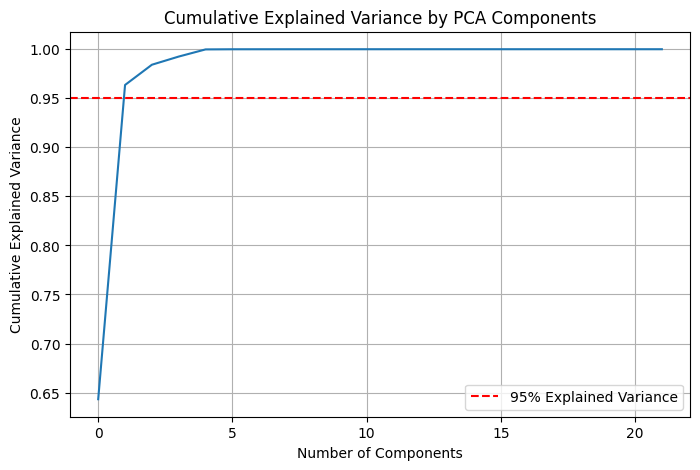

In [65]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# Fit PCA on the training data
pca = PCA().fit(X_train)

# Calculate the cumulative sum of explained variances
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(cumulative_explained_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by PCA Components')
plt.grid(True)

# This line draws a dashed line at 0.95 which is the threshold for the explained variance
plt.axhline(y=0.95, linestyle='--', color='red', label='95% Explained Variance')
plt.legend(loc='best')

plt.show()

So we can see clearly here that there are too many features that are related to each other.

In [66]:
from sklearn.decomposition import PCA

# Define the PCA and KNN pipeline
pca_knn_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=0.95)),  # Retain 95% of the variance or choose the number of components
    ('classifier', KNeighborsClassifier(n_neighbors=5))
])

# Fit the model
pca_knn_pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pca_knn_pipeline.predict(X_test)

# Evaluate the model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[96839    47]
 [  163   202]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     96886
         1.0       0.81      0.55      0.66       365

    accuracy                           1.00     97251
   macro avg       0.90      0.78      0.83     97251
weighted avg       1.00      1.00      1.00     97251



### Decision Tree Classifier

In [67]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Initialize the DecisionTreeClassifier
decision_tree = DecisionTreeClassifier(max_depth=10, random_state=42)

# Train the classifier on the training data
decision_tree.fit(X_train, y_train)

# Make predictions on the test data
y_pred = decision_tree.predict(X_test)

# Evaluate the classifier
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[96835    51]
 [  135   230]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     96886
         1.0       0.82      0.63      0.71       365

    accuracy                           1.00     97251
   macro avg       0.91      0.81      0.86     97251
weighted avg       1.00      1.00      1.00     97251



### Naive Bayes

We know naive bayes works under the assumption that the variables are independant. From my work above we can clearly see the variables are not. However we can use the pca results to try the model.

In [71]:
from sklearn.naive_bayes import GaussianNB

# Create a pipeline that includes PCA and GaussianNB
nb_pipeline = Pipeline([
    ('pca', PCA(n_components='mle')),  # 'mle' can automatically choose the number of components
    ('naive_bayes', GaussianNB())
])

# Fit the pipeline to the training data
nb_pipeline.fit(X_train, y_train)

# Make predictions on the test data
y_pred = nb_pipeline.predict(X_test)

# Evaluate the classifier
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[93905  2981]
 [   68   297]]
              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98     96886
         1.0       0.09      0.81      0.16       365

    accuracy                           0.97     97251
   macro avg       0.54      0.89      0.57     97251
weighted avg       1.00      0.97      0.98     97251



Obviously performing quite poorly due to the nature of the features. Let me try and ensemble classifer so i have the set up ready.

### Stacking Ensemble Classifer + gradient Boosting Classifer

- Stacking combines diverse models by learning how to best blend their strengths using another model.

- Gradient Boosting builds a sequence of models in a way that each subsequent model focuses on correcting the mistakes of the previous ones.

In [72]:
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Define base learners
base_learners = [
    ('knn', KNeighborsClassifier(n_neighbors=2)),  # best_k determined from previous analysis
    ('dt', DecisionTreeClassifier(max_depth=10)),  # best_depth determined from tuning
    ('nb', GaussianNB())
]

# Initialize the Stacking Classifier with Gradient Boosting as the final estimator
stack_model = StackingClassifier(estimators=base_learners, final_estimator=GradientBoostingClassifier(random_state=42))

# Fit the stacking classifier
stack_model.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred = stack_model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[96839    47]
 [  244   121]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     96886
         1.0       0.72      0.33      0.45       365

    accuracy                           1.00     97251
   macro avg       0.86      0.67      0.73     97251
weighted avg       1.00      1.00      1.00     97251



So clearly we can see the problem seems to be a lack of variety in my features I think while they are specific they are not broad enough. I will explore more features in the next notebook - Data_Exploreation 2.